# Coarsegraining on a curved surface and calculating nematic defects

### Required software

- Python >= 3.6
- Numpy
- Pandas
- [igraph for Python](https://anaconda.org/conda-forge/python-igraph) 

Make sure you have the latest version of igraph: v0.8.2! The installer might take an older version by default. To force the latets version:

`conda install -c conda-forge python-igraph=0.82`

### Method outline (more detailed methods are given in the package documentation)

Given a triangulation of the cellular network on a curved surface, here we obtain:

- Define the graph of the triangular mesh, where every triangle is a node and the neighbors of each triangle (at most 3) define the edges of the graph.
- For every triangle $t$ in the mesh, find the neighborhood of order $k$, $N^t_k$, with area $A^t_k$, such that
$$\mathrm{min}( |A^t_k - A_\mathrm{coarse}| )$$
where $A_\mathrm{coarse}$ is the preferred area of coarse graining. This should give a set of triangle ids that form a patch around each triangle with an area closest to the preferred coarse graining area. 
- Smoothening the tensors $q_{ij}^r$ defined on each traingle $r$ that lies inside the patch centered around triangle $t$, by taking the local area weighted average
$$Q^t_{ij} = \frac{1}{A^t_k}\sum_{r\in N^t_k} a^r q_{ij}^r$$
where $A^t$ is the area of the patch and $a^r$ is the area of each triangle.
- For the smoothened nematic field of triangle elongation tensors, $Q_{ij}^t$, defined for each triangle $t$, calculate the nematic defects for each triangle $t$ by calculating the rotation angle of the smoothened elongation tensors while moving around a closed contour centered around triangle $t$, $\bar{\Theta}^t$ (see further below in this notebook). 

In [13]:
%load_ext autoreload
%autoreload 2

import os
import pwd
import sys
import multiprocessing as mp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import igraph as ig

# Load Curved Tissue Miner packages
import curvedtm
from curvedtm import MMCoarse
from curvedtm import MMTool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
### Set path to directory containing the Tissue Miner movies and the name of specific name.
username = 'paijmans'

datapath_tissue_miner = '/home/' + username + '/MovieData/' 

movie_name = '20161110_116hrAEL_400nM20E'

datapath_movie_name   = os.path.join(datapath_tissue_miner, movie_name)
datapath_movie_frames = os.path.join(datapath_movie_name, 'frames/')

In [15]:
curved_surface = curvedtm.CurvedTM(datapath_movie_name, 
                                   network_type = 'subcellular_triangles',  
                                   frames_to_process = [-1], 
                                   refresh_DB_tables = False, 
                                   refresh_fundaments = True, 
                                   refresh_geometry = True,
                                   refresh_triangle_state = True,
                                   refresh_cell_state = True)

Output directory: /home/paijmans/MovieData/20161110_116hrAEL_400nM20E/frames
Tissue Miner DB Loader for movie 20161110_116hrAEL_400nM20E inititalized.
Triangulation of movie 20161110_116hrAEL_400nM20E for network type subcellular_triangles inititalized.
Execute 'run()','run_parallel()' or 'run_frame(frameIdx)' to start the Curved Tissue Miner.


### Set index of frame to process

In [16]:
frameIdx = 0

## Coarse grain tensors using local neighborhoods

Below, we obtain for every triangle $n$ in the mesh its closed neighborhood of order $k_n$, such that the area of the neighborhood $A_n$ is closest to a set reference area. A neighborhood of order $k_n$ is defined as the set of triangle ids that can be reached within $k_n$ hops in the graph, starting at triangle $n$. The function 'get_patches_through_mesh_neighborhood' below returns a list of lists, which contains for every triangle in the mesh (this 'super' list is indexed by triangle id), a list of triangle ids that are in the neighborhood. 

The arguments of 'get_patches_through_mesh_neighborhood', next to the frameIdx and a curved_surface object, are:

- 'patch_prefered_area': The reference area for the neighborhood size. The mean triangle area is about 1.1 (see below).
- 'starting_order': For every triangle, the algorithm starts searching from this neighborhood order in order to obtain a neighborhood area that is closest to the reference. The closer the starting order is to the final order the faster the algorithm.  

In the function 'coarse_grain_tensors' we take the area weighted average of the elongation tensor over the obtained patches as well for certain scalar properties of the triangles (curvatures etc).

In [ ]:
# Hoe to load tables from database.
?curved_surface.load_data_tables

In [17]:
# Load table of all triangles in the mesh and calculate mean area.
triangles = curved_surface.load_data_tables(frameIdx, ['/subcellular_triangles/triangles'], 'list')[0]

print('Mean triangle area:', triangles['area'].mean())

Mean triangle area: 1.1021491900094937


In [18]:
### Set the preferred area for the local neighborhood. 500 is a good size. (Mean triangle area is ~1 micron^2).
coarsegrain_area = 500

### The order of the neighborhood used as a start. The algorithm will, for each patch, look for an order of the neighborhood
# such that the area of the neighborhood is closest to the preferred area. 
# The closer this starting order is to the mean, the faster the algorith converges. 
coarsegrain_starting_order = 15

# Return a list with for each triangle in the mesh, a list of triangle ids that are in its neighborhood.
# Also return the igraph graph object, g, which we will need below.
patches_triangles_id, g = MMCoarse.get_patches_through_mesh_neighborhood(frameIdx,\
                                                                         curved_surface,\
                                                                         starting_order = coarsegrain_starting_order,\
                                                                         patch_prefered_area = coarsegrain_area,
                                                                         return_graph=True)
# Coarse grain tensor over these patches.
MMCoarse.coarse_grain_tensors(frameIdx,\
                              datapath_movie_frames,\
                              patches_triangles_id,\
                              coarsegrain_area,\
                              scalars_to_coarsegrain = ['elongation_tensor_norm', 'gaussian_curvature',  'mean_curvature', 'area'])

## Plot information of neighborhood areas and #triangles

Fix coarse grain area, $A_\mathrm{coarse}$, show distributions of neighborhood areas and #triangles

(Neighborhood coarse area: 500 ) - mean #triangles: 466.77990578423044 mean area: 499.17278244957066


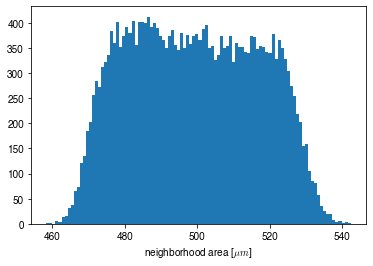

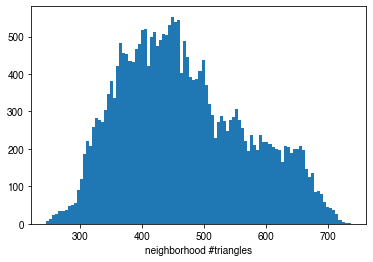

In [20]:
#triangles = MMTool.table_io_per_frame(datapath_movie_frames, 'triangles', frameIdx, network_type = 'subcellular_triangles')
triangles_area = triangles.area.values
triangles_id   = triangles.index.values

patches_area = np.array([triangles_area[tids].sum() for tids in patches_triangles_id])
patches_num_triangles = np.array([len(tids) for tids in patches_triangles_id])

print('(Neighborhood coarse area:', coarsegrain_area, ') - mean #triangles:', np.array(patches_num_triangles).mean(), 'mean area:', np.array(patches_area).mean() )


plt.hist(patches_area, 100)
plt.xlabel('neighborhood area [$\mu m$]')
plt.show()

plt.hist(patches_num_triangles, 100)
plt.xlabel('neighborhood #triangles')
plt.show()

Fix order of all neighborhoods, show distributions of neighborhood area and #triangles

(Neighborhood order: 17 ) - mean #triangles: 478.35384971812493 mean area: 526.2498938486524


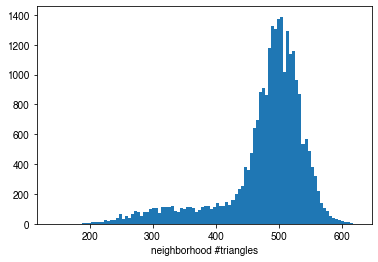

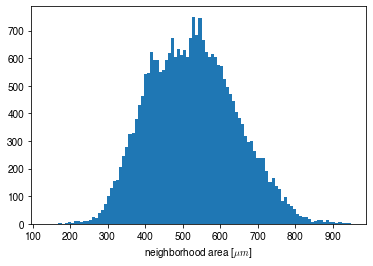

In [21]:
pref_order = 17

triangles_neigborhood = g.neighborhood(triangles_id, order=pref_order)

patches_num_triangles = g.neighborhood_size(triangles_id, order=pref_order)
patches_area = [triangles_area[neighborhood].sum() for neighborhood in triangles_neigborhood]

print('(Neighborhood order:', pref_order, ') - mean #triangles:', np.array(patches_num_triangles).mean(), 'mean area:', np.array(patches_area).mean() )

plt.hist(patches_num_triangles, 100)
plt.xlabel('neighborhood #triangles')
plt.show()

plt.hist(patches_area, 100)
plt.xlabel('neighborhood area [$\mu m$]')
plt.show()

## Find defects in smooth nematic field

### Obtain closed contour around every patch in counterclockwise direction

Given the closed neighborhood (patches) of each triangle obtained above and contained in the list 'patches_triangles_id', below we obtain the oriented closed contour around each of the neighborhoods. The closed contour is an ordered list of triangle ids, that form a connected set of triangles that can be traversed in counterclockwise direction around a neighborhood. Note that here we use the neighborhoods we obtained for smoothing the nematic field to also obtain the contours. In general we could also use contours of a different size to find the nematic defects. To do this, we have to obtain the neighborhoods for a different preferred area and use these in the function below to obtian the contours.

We obtain the oriented closed contour around a neighborhood via:

1. Find all the triangle edges that only occur once in the neighborhood: These edges form the boundary of the neighborhood.
2. Given the edges on the boundary, find all the vertices of the triangle network connected to these edges.
3. Find all the triangles connected to these vertices that also lie inside the neighborhood.
4. Create a graph 'g' from all the triangles that form the closed contour.
5. Use the function 'g.get_all_simple_paths(t1, t2)' from the igraph package, with t1 and t2 two arbitrary neighboring triangles (nodes) in the graph g. This functions returns all possible paths between t1 and t2 that visit each node in g only once. It will return the trivial path t1->t2 and the path going around the contour t1 -> ... -> t2. The latter we need. We use the normal vector on the surface to make sure the direction of traversing the path in in the counterclockwise direction.

In [22]:
### Get ordered contour of each path     
patches_contour_ordered_triangles_id = MMCoarse.get_ordered_triangles_on_contours(frameIdx, curved_surface, patches_triangles_id, g)

print('Contour of triangle ids for the contour centered around the triangle with id 0: \n\n', patches_contour_ordered_triangles_id[0])

Contour of triangle ids for the contour centered around the triangle with id 0: 

 [ 2657 19364 19363 19362  5223  5224  5225  5219 10574 10575 10576 10570
 10571  5881  5877  5878  5879  4506  4507  4501  4502 22940 22939 22938
  8749  8750  8751  8511  8510  8509  8945  8944  8943 11288 11289 11290
 11858 11857 11856 25505 25510 25509 17953 17954 17955 17671 17676 14997
 14998 14999 12920 12925  9651  9652  9653  9654 17534 17535 17536 11411
 11410 11416 22060 22059 22064  9985  9986  9987 13561 13560 13565 20802
 20801 20800  9745  9746 16611 16610 10381 10382 10383  5606  5605 20669
 20670 20667  2661  2662  2663]


#### Plot example of a neighborhood and contour

To give a better idea of what we have obtained so far, below we plot the neighborhood and contour of a neighborhood / patch.

In [ ]:
?MMCoarse.plot_patch

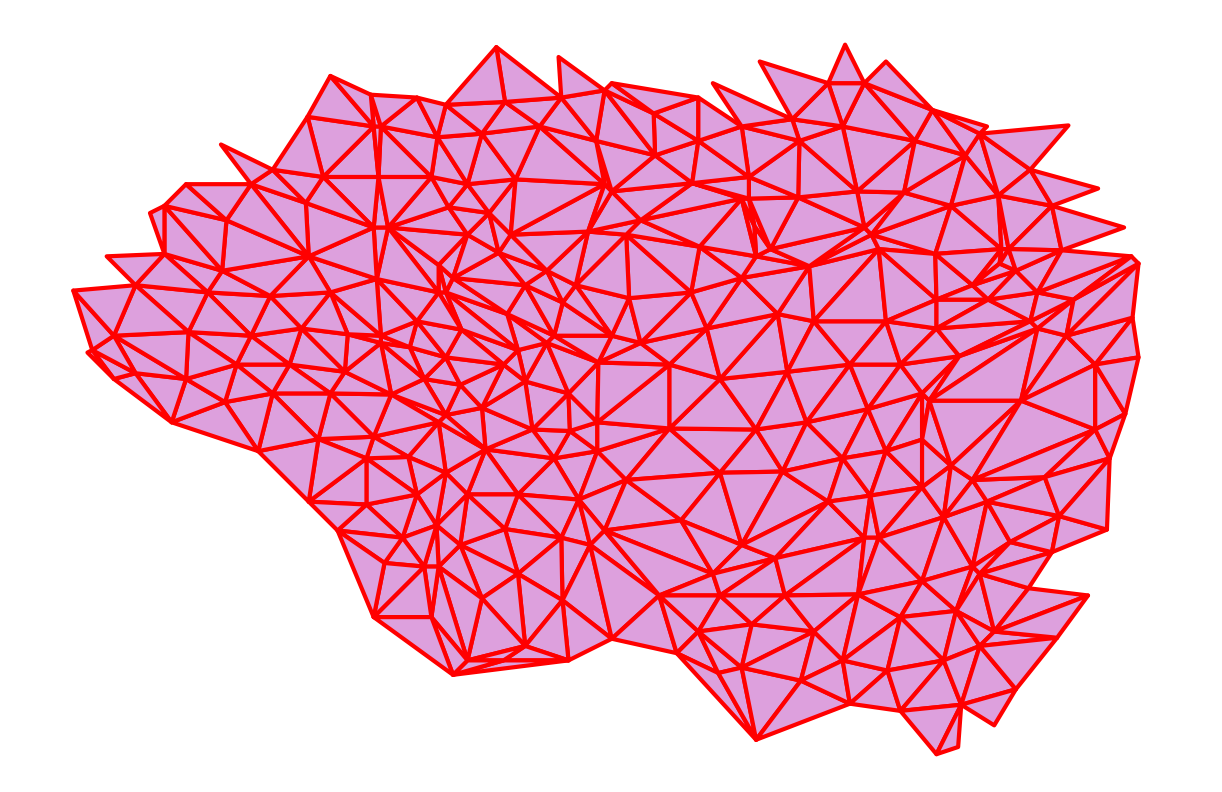

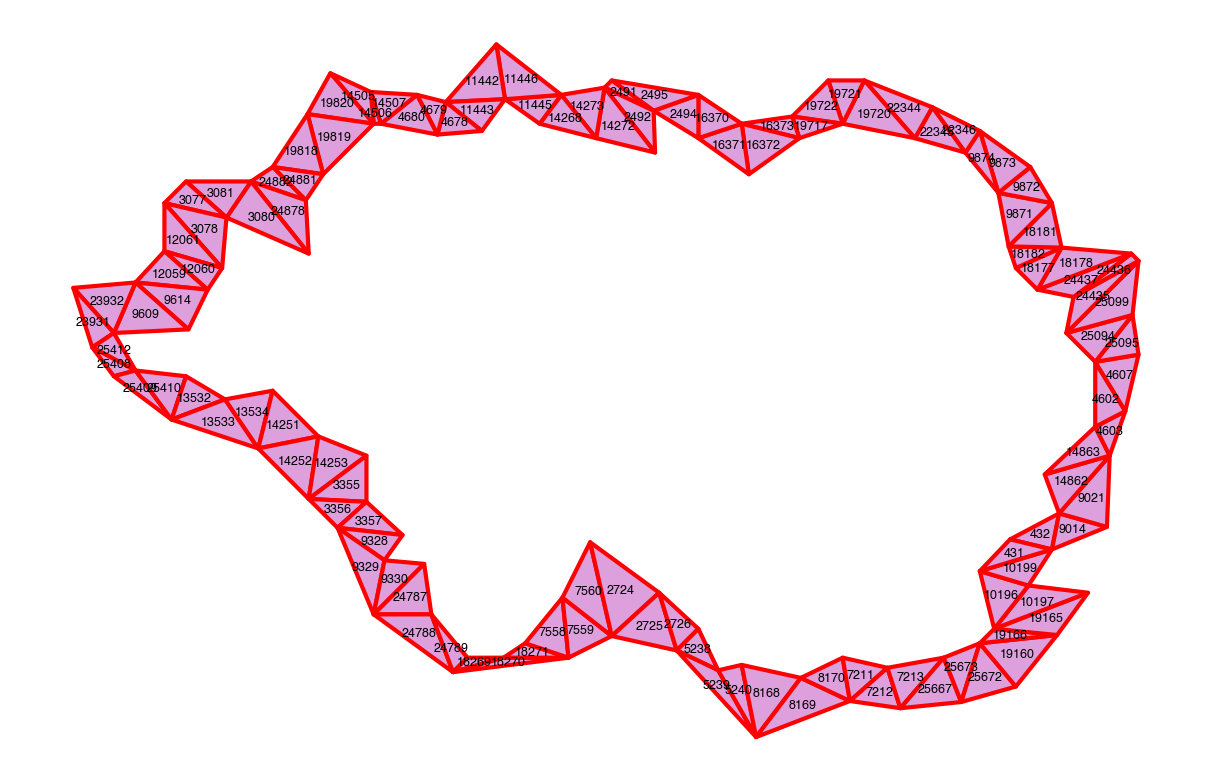

In [23]:
patch_id = 42

triangle_vertices = curved_surface.load_data_tables(frameIdx, ['/subcellular_triangles/vertices'], 'list')[0]

# Get triangle ids in neighborhood and the contour around that neghborhood.
neighborhood_triangles_id = patches_triangles_id[patch_id]
contour_triangles_id      = patches_contour_ordered_triangles_id[patch_id]

# Plot all triangles in the neighborhood.
fig, ax = MMCoarse.plot_patch(neighborhood_triangles_id, triangle_vertices, triangles, plotIds=False)
plt.show()

# Plot all triangles on the contour around the neighborhood.
fig, ax = MMCoarse.plot_patch(contour_triangles_id, triangle_vertices, triangles, plotIds=True)
#plt.savefig('./temp.png')
plt.show()

### Calculate rotation angles $\Theta_n$ in the smooth nematic tensor field while going around a contour.

- Calculate the smallest angle $\theta_{i, i+1}$ between the smooth nematic tensors on all pairs of consecutive triangles $t_i$ and $t_{i+1}$ going around the contour,

$$\theta_{i,i+1} = \min[ \arccos(\mathbf{q}_i\cdot\mathbf{q}_{i+1}), \pi - \arccos(\mathbf{q}_i\cdot\mathbf{q}_{i+1}) ]\in [0,\pi/2]$$

- Find the direction, $s_i$, of rotating $\mathbf{q}_i$ on $\mathbf{q}_{i+1}$, where $s_i = 1$ means counterclockwise rotation and $s_i = -1$ mean clockwise rotation w.r.t. the oriented surface. Given the unit normal on triangle $i$, $\mathbf{n}_i$, the direction of rotation is defined as

$$ s_i = \mathrm{sign}[(\mathbf{q}_i\times\mathbf{q}_{i+1})\cdot\mathbf{n}_i] \in \{-1,1\}$$

- Find the total rotation angle of the smooth nematic field, $\Theta_n$, traversing the contour centered around triangle $n$, as

$$ \Theta_n = \sum_i \theta_{i,i+1} s_i $$

- Normalize the angle by $2\pi$: 

$$\bar{\Theta}_n = \frac{\Theta_n}{2\pi} $$

In [24]:
## OPTION: Rotate all smooth triangle elongation tensors into the xy-plane before calculatin the angle between consecutive tensors.
use_inplane_tensors = True

### Load smooth elongation tensors and normal unit vector on every triangle for surface orientation.
# We set the neighborhood area for obtaining the contour equal to the neighborhood area for smoothing the nematic field. This does not have to be equal.
contour_patch_area = coarsegrain_area

# Set network name for smoothened elongation tensors. 
network_name = 'patches_' + str(coarsegrain_area)
elongation_tensor_table_path = '/' + network_name + '/elongation_tensor'

# Load the smooth field of nematic tensors which we created above.
required_tables = [elongation_tensor_table_path, '/subcellular_triangles/triangles']
patches_elongation_tensor, triangles = curved_surface.load_data_tables(frameIdx, tables_name=required_tables, return_type='list')
patches_elongation_tensor = patches_elongation_tensor.values.reshape(-1,3,3)

# Load unit normal vectors on the triangles (required for orientation of the surface).
triangles_normal = triangles[['normal_x', 'normal_y', 'normal_z']].values

### Calulate the angle of rotation of the tensor around every contour. 
patches_contour_elongation_total_rotation = MMCoarse.calculate_patch_contour_tensor_rotation_angle(patches_contour_ordered_triangles_id,\
                                                                                                   patches_elongation_tensor,\
                                                                                                   triangles_normal,\
                                                                                                   use_inplane_tensors=use_inplane_tensors)

print('Rotation angles (normalized by 2pi) around first 10 neighborhoods:\n', patches_contour_elongation_total_rotation[:10])

Rotation angles (normalized by 2pi) around first 10 neighborhoods:
 [-0.01142171  0.00646022 -0.0193349  -0.01465899 -0.00974419  0.16142808
  0.0613384  -0.28614257 -0.09967495 -0.21865547]


### Save rotation angles $\theta_n$

For each contour centered around triangle $n$, save the obtained normalized total angle, $\bar{\Theta}_n$, so we can color each triangle by the rotation angle of the contour centered around that triangle.

In [25]:
# Set column name in triangles table for defect angle output.
contour_total_rotation_angle_name = 'patches_' + str(coarsegrain_area) + '_contour_' + str(contour_patch_area)
if use_inplane_tensors:
    contour_total_rotation_angle_name += '_in_plane_tensors'

### Save data to disk.
triangles[contour_total_rotation_angle_name] = patches_contour_elongation_total_rotation
triangles= MMTool.table_io_per_frame(datapath_movie_frames, table_name = 'triangles', frameIdx = frameIdx, network_type = 'subcellular_triangles',
                                     action = 'save', table = triangles)

### Output the nematic defect angles and smooth tensor field to vtk files

Use the script $\texttt{curvedtm2vtk}$ to output the data in vtk format. This can also be run from console from within the movie root directory.

In [45]:
### Set location of python interperter, if left empty use hashbang (first line of script starting with #! + path/to/interperter) in the 'curvedtm2vtk.py' script.
python_interp = ''

### Save current working dir, assuming this is where the package resides.
curwd = os.getcwd()
curvedtm2vtk_path = os.path.join(curwd, 'curvedtm2vtk.py')

# Set current location to movie root dir.
os.chdir(datapath_movie_name)

### Run the script.

## Output smooth cell elongation field vtk file
# Set networks (-n) to 'patches_500'
# Set tensor to output (-t) to 'elongation_tensor'
# Set eigenvector to output from tensor (-e) corresponding to 'max' eigenvalue
!$python_interp $curvedtm2vtk_path -g $frameIdx -n $network_name -t 'elongation_tensor' -e 'max'

## Output the triangles colored by nematic defect angle with vtk file
# Set network (-n) to 'subcellular_triangles'
# Set output scalar (-s) to column name set in contour_total_rotation_angle_name.
!$python_interp $curvedtm2vtk_path -g $frameIdx -n subcellular_triangles -s $contour_total_rotation_angle_name 

# Return to package dir.
os.chdir(curwd)

Loading tensor 'elongation_tensor' (eigenvector loaded: 'max' eigenvalue) - network type: patches_500
Writing tensors on mesh for frame 0 to file patches_500_tensors_0000.vtk
Writing subcellular_triangles faces for frame 0 to file subcellular_triangles_faces_0000.vtk
Loading tensor 'elongation_tensor' (eigenvector loaded: 'max' eigenvalue) - network type: subcellular_triangles
Writing tensors on mesh for frame 0 to file subcellular_triangles_tensors_0000.vtk


## Function to both smoothen triangle elongation tensors and obtain defects at once

The function below merges all steps above in one. Note that we can choose different preferred areas for coarse graining the nematic field (argument named: 'coarsegrain_area') and for obtaining the contour (argument named: 'contour_patch_area'). This means we can coarse grain on one length scale but obtain the defects in the field obtained using contours with different (smaller) size. In the example below I set both areas equal by default.

In [ ]:
?MMCoarse.calculate_nematic_field_and_defects

In [46]:
# Set index of frame to process
frameIdx = 1
# Rotate all elongation of coarse grained / smooth elongation tensors into the xy-plane before calculating defect. (Attempt to remove effect of surface) 
use_inplane_tensors = True

### Set size for smoothing nematic field.
#coarsegrain_area, coarsegrain_starting_order = 1000, 20
#coarsegrain_area, coarsegrain_starting_order = 500, 15
#coarsegrain_area, coarsegrain_starting_order = 150, 9
#coarsegrain_area, coarsegrain_starting_order = 100, 7

coarsegrain_area, coarsegrain_starting_order = 350, 12

### Set size for contour.
contour_patch_area, contour_starting_order = coarsegrain_area, coarsegrain_starting_order
#contour_patch_area, contour_starting_order = 500, 15
#contour_patch_area, contour_starting_order = 150, 9
#contour_patch_area, contour_starting_order = 100, 7  

### List of triangle scalars (names of columns in the triangles table), that should be coarse grained using the neighborhoods.
scalars_to_coarsegrain = ['area', 'elongation_tensor_norm']

MMCoarse.calculate_nematic_field_and_defects(frameIdx,\
                                             datapath_movie_frames,\
                                             curved_surface,\
                                             coarsegrain_area,\
                                             coarsegrain_starting_order,\
                                             contour_patch_area,\
                                             contour_starting_order,\
                                             scalars_to_coarsegrain,\
                                             use_inplane_tensors,\
                                             refresh=False)

True

In [42]:
### Check that coarse grained quantaties are saved in triangles table
triangles = curved_surface.load_data_tables(frameIdx, ['/subcellular_triangles/triangles'], 'list')[0]
triangles.columns

Index(['triangle_id', 'cell_id', 'vertex_id_1', 'vertex_id_2', 'vertex_id_3',
       'dr_12_x', 'dr_12_y', 'dr_12_z', 'dr_13_x', 'dr_13_y', 'dr_13_z',
       'area', 'normal_x', 'normal_y', 'normal_z', 'rotation_angle_x',
       'rotation_angle_y', 'rotation_angle_z', 'elongation_tensor_norm',
       'elongation_tensor_twophi', 'mean_curvature', 'gaussian_curvature',
       'neighborhood_elongation_area', 'neighborhood_elongation_tensor_norm',
       'neighborhood_elongation_mean_curvature',
       'neighborhood_elongation_gaussian_curvature', 'neighborhood_area',
       'neighborhood_tensor_norm', 'neighborhood_mean_curvature',
       'neighborhood_gaussian_curvature', 'patches_1000_area',
       'patches_1000_tensor_norm', 'patches_1000_mean_curvature',
       'patches_1000_gaussian_curvature', 'patches_500_contour_angle',
       'patches_100_contour_angle', 'patches_350_area',
       'patches_350_elongation_tensor_norm',
       'patches_350_contour_350_in_plane_tensors'],
      dtyp

### Run single frame parameter sweep

Below we perform a sweep of different neighborhood / patch sizes both for smoothing the nematic field and obtaining the defects.

In [ ]:
# Set index of frame to process
frameIdx = 1
# Use in-plane tensors (Attempt to remove effect of surface) 
use_inplane_tensors = True
# Set Neighborhood starting order
contour_starting_order, coarsegrain_starting_order = 10, 10

for patch_size in [400, 300, 200, 100]:
    coarsegrain_area, contour_patch_area = patch_size, patch_size
    MMCoarse.calculate_nematic_field_and_defects(frameIdx,\
                                                 datapath_movie_frames,\
                                                 curved_surface,\
                                                 coarsegrain_area,\
                                                 coarsegrain_starting_order,\
                                                 contour_patch_area,\
                                                 contour_starting_order,\
                                                 scalars_to_coarsegrain,\
                                                 use_inplane_tensors,\
                                                 refresh=False)

### Run multiple frames in paralell

Functions below only intended for running multiple frames / conditions using the paralell processing package.

In [ ]:
def run_frame(frameIdx):
    """ Wrapper function for multiprocessing map. Should only have one argument.
    """
    
    print('Processing frame' ,frameIdx, '.')
            
    try:
        MMCoarse.calculate_nematic_field_and_defects(frameIdx, datapath_movie_frames, curved_surface,\
                                                     coarsegrain_area, coarsegrain_starting_order,
                                                     contour_patch_area, contour_starting_order, refresh=False)
    except Exception as e: 
        print('ERROR: Something went wrong in frame', frameIdx, 'while coarsening nematic field.')
        print(e)   

In [ ]:
frames = list(range(200,205))

pool = mp.Pool(processes=5)
pool.map(run_frame, frames)
pool.close()

### Load important data

In [11]:
frameIdx = 0

dcel, triangles, triangle_vertices, triangles_elongation_tensor =\
    curved_surface.load_data_tables(frameIdx, 
                                    tables_name=['/subcellular_triangles/dbonds', '/subcellular_triangles/triangles',\
                                                 '/subcellular_triangles/vertices', '/subcellular_triangles/elongation_tensor'],
                                    return_type='list')
triangles_elongation_tensor = triangles_elongation_tensor.values.reshape(-1,3,3)